# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from scipy.stats import zscore

In [4]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [5]:
from catboost import Pool

In [6]:
from deepctr.models import DeepFM

In [7]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

In [8]:
from sklearn.metrics import log_loss, roc_auc_score

# Loading data

### Main Dataset Loader

In [21]:
day1_df = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\30-12-2023.csv")
day2_df = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\31-12-2023.csv")
day3_df = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\01-01-2024.csv")
day4_df = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\02-01-2024.csv")
day5_df = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\03-01-2024.csv")
day6_df = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\04-01-2024.csv")
day7_df = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\05-01-2024.csv")
day8_df = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\main dataset\\06-01-2024.csv")

In [22]:
dfs_lst = [day1_df, day2_df, day3_df, day4_df, day5_df, day6_df, day7_df, day8_df]

### Publisher Common Feature Loader

In [30]:
pub_com_users = pd.read_csv("C:\\Users\\ofri\\Desktop\\ofri\\B.sc\\semester e\\Starship\\publisher_common_features.csv")

In [31]:
pub_com_users["feature"].value_counts()

COMMON_USER_CITY                1801
COMMON_USER_COUNTRY             1801
COMMON_USER_REGION              1800
COMMON_USER_REGION_CODE         1800
COMMON_SOURCE_UPPER_TAXONOMY    1583
COMMON_USER_DMA                 1505
Name: feature, dtype: int64

# Filter for users

In [23]:
user_counts = {}
for df in dfs_lst:
    for user in set(df['userId']):
        user_counts[user] = user_counts.get(user, 0) + 1

# Identify users who appeared in at least two DataFrames
common_users = {user for user, count in user_counts.items() if count >= 2}

# Step 2: Filter rows with non-null values in 'spClicks' and 'rcClicks'
filtered_dfs = []
for df in dfs_lst:
    filtered_df = df[df['userId'].isin(common_users) & df['spClicks'].notnull() & df['rcClicks'].notnull()]
    filtered_dfs.append(filtered_df)

In [24]:
print("""Number of sessions from sampled users each day:
      Day 1: %d
      Day 2: %d
      Day 3: %d
      Day 4: %d
      Day 5: %d
      Day 6: %d
      Day 7: %d
      Day 8: %d
      """ %tuple(map(len, filtered_dfs)))

Number of sessions from sampled users each day:
      Day 1: 306963
      Day 2: 306586
      Day 3: 303492
      Day 4: 312241
      Day 5: 318581
      Day 6: 314520
      Day 7: 313038
      Day 8: 314548
      


In [25]:
filtered_days = [df.sample(n=250000, random_state=42) for df in filtered_dfs]

Combining data frames for handling missing values:

In [28]:
combined_df = pd.concat(filtered_days)

# Handling missing values

In [30]:
def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
    
    if total == 0:
        print("no missing values left")
            
missing_cols(combined_df)

region => 3254
country => 33
sessionReferrer => 892297


In [31]:
def perc_missing(df):
    '''prints out columns with missing values with its %'''
    for col in df.columns:
        pct = df[col].isna().mean() * 100
        if (pct != 0):
            print('{} => {}%'.format(col, round(pct, 2)))
    
perc_missing(combined_df)

region => 0.16%
country => 0.0%
sessionReferrer => 44.61%


## Inferring features
Inferring features that are associated with user according to other records of the same user.

In [32]:
def infer_feature_by_user(feature_name):
    combined_df[feature_name] = combined_df.groupby('userId')[feature_name].transform(lambda x: x.ffill().bfill())

infer_feature_by_user('country')
infer_feature_by_user('region')

In [34]:
missing_cols(combined_df)

region => 1939
sessionReferrer => 892297


Now there is a very small number of rows without country, so it will not change much to drop them.

In [35]:
combined_df = combined_df.dropna(subset=['region'])

missing_cols(combined_df)

sessionReferrer => 891338


## Reduce memory usage:

In [36]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998061 entries, 953203 to 550899
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   sourceItemId           int64  
 1   itemId                 int64  
 2   placement              object 
 3   userId                 object 
 4   publisherId            object 
 5   publisherLanguage      object 
 6   city                   object 
 7   region                 object 
 8   country                object 
 9   dma                    int64  
 10  sourceUpperTaxonomy    object 
 11  sourceAlchemyTaxonomy  object 
 12  sessionReferrer        object 
 13  userQualityLoyalty     object 
 14  pub_group              object 
 15  upperTaxonomy          object 
 16  alchemyTaxonomy        object 
 17  rcClicks               float64
 18  spClicks               float64
 19  date                   int64  
 20  clicks                 int64  
 21  pvs                    int64  
 22  session_depth 

In [37]:
combined_df["rcClicks"] = combined_df["rcClicks"].astype('float32')
combined_df["spClicks"] = combined_df["spClicks"].astype('float32')
combined_df["clicks"] = combined_df["clicks"].astype('int32')
combined_df["pvs"] = combined_df["pvs"].astype('int32')
combined_df["dma"] = combined_df["dma"].astype('int32')
combined_df["session_depth"] = combined_df["session_depth"].astype('int32')
combined_df["userQualityLoyalty"] = combined_df["userQualityLoyalty"].astype('category')
combined_df["placement"] = combined_df["placement"].astype('category')
combined_df["publisherLanguage"] = combined_df["publisherLanguage"].astype('category')
combined_df["city"] = combined_df["city"].astype('category')
combined_df["region"] = combined_df["region"].astype('category')
combined_df["country"] = combined_df["country"].astype('category')
combined_df["sessionReferrer"] = combined_df["sessionReferrer"].astype('category')
combined_df["upperTaxonomy"] = combined_df["upperTaxonomy"].astype('category')
combined_df["alchemyTaxonomy"] = combined_df["alchemyTaxonomy"].astype('category')
combined_df["sourceUpperTaxonomy"] = combined_df["sourceUpperTaxonomy"].astype('category')
combined_df["sourceAlchemyTaxonomy"] = combined_df["sourceAlchemyTaxonomy"].astype('category')
combined_df["sourceItemId"] = combined_df["sourceItemId"].astype('category')
combined_df["itemId"] = combined_df["itemId"].astype('category')
combined_df["publisherId"] = combined_df["publisherId"].astype('category')

combined_df["date"] = pd.to_datetime(combined_df["date"], format='%Y%m%d')

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998061 entries, 953203 to 550899
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   sourceItemId           category      
 1   itemId                 category      
 2   placement              category      
 3   userId                 object        
 4   publisherId            category      
 5   publisherLanguage      category      
 6   city                   category      
 7   region                 category      
 8   country                category      
 9   dma                    int32         
 10  sourceUpperTaxonomy    category      
 11  sourceAlchemyTaxonomy  category      
 12  sessionReferrer        category      
 13  userQualityLoyalty     category      
 14  pub_group              object        
 15  upperTaxonomy          category      
 16  alchemyTaxonomy        category      
 17  rcClicks               float32       
 18  spClicks          

All records share the same publisher group- no information is given with this feature.

In [38]:
print(combined_df["pub_group"].value_counts())
combined_df = combined_df.drop(["pub_group"], axis=1)

o_non_en    1998061
Name: pub_group, dtype: int64


## Categorize features

In [43]:
combined_df["sessionReferrer"] = combined_df["sessionReferrer"].astype('str')

mapping = {
    'google': 'SEARCH ENGINE',
    'bing': 'SEARCH ENGINE',
    'yahoo': 'SEARCH ENGINE',
    'baidu' : 'SEARCH ENGINE',
    'yandex' : 'SEARCH ENGINE',
    'duckduckgo' : 'SEARCH ENGINE',
    'aol' : 'SEARCH ENGINE',
    'naver' : 'SEARCH ENGINE',
    'seznam.cz' : 'SEARCH ENGINE',
    'facebook': 'SOCIAL MEDIA',
    'twitter': 'SOCIAL MEDIA',
    'instagram': 'SOCIAL MEDIA',
    'linkedin' : 'SOCIAL MEDIA',
    'threads' : 'SOCIAL MEDIA',
    'taboola' : 'TABOOLA', 
    'nan' : 'DIRECT',
    '_sessionPending_' : 'OTHER',
}

# Function to replace keywords based on the mapping
def replace_keywords(referrer):
    if referrer in mapping.values():
            return referrer
    for keyword, replacement in mapping.items():
        if keyword in referrer.lower():
            return replacement
    return referrer


combined_df['sessionReferrer'] = combined_df['sessionReferrer'].apply(replace_keywords)

In [44]:
def slice_sub_subjects(s : str):
    idx = s.find('~')
    if idx == -1:
        return s
    return s[ : idx]

combined_df['upperTaxonomy'] = combined_df['upperTaxonomy'].apply(slice_sub_subjects)
combined_df['upperTaxonomy'].value_counts()

NEWS             687743
ENTERTAINMENT    429295
LIFE             397009
SPORTS           260560
BUSINESS          96523
TECH              56386
OPINIONS          36463
INDIA             15432
AUTOS             12865
VIRAL              2974
ENVIRONMENT        1060
HUMOR               747
HISTORY             644
TOP-NEWS            149
OBSOLETE            142
PODCASTS             69
Name: upperTaxonomy, dtype: int64

# Handling anomalies

## Detedcting anomalies

In [45]:
combined_df[combined_df["rcClicks"].notnull()]["rcClicks"].describe()

count    1.998061e+06
mean     1.980559e+01
std      3.855762e+01
min      0.000000e+00
25%      2.000000e+00
50%      7.000000e+00
75%      2.000000e+01
max      1.264000e+03
Name: rcClicks, dtype: float64

<Figure size 1000x600 with 0 Axes>

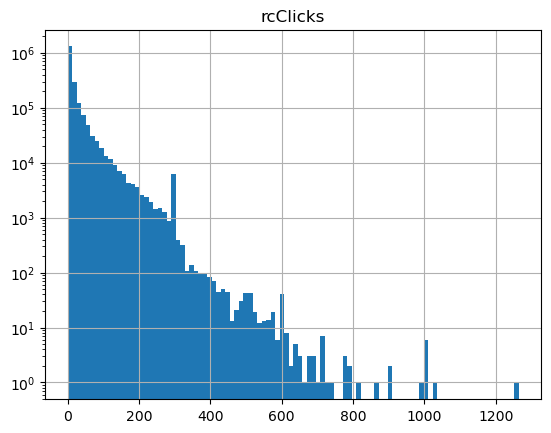

In [46]:
plt.figure(figsize=(10, 6))
combined_df.hist(column=['rcClicks'], bins= 100)
plt.yscale('log')


<Figure size 1000x600 with 0 Axes>

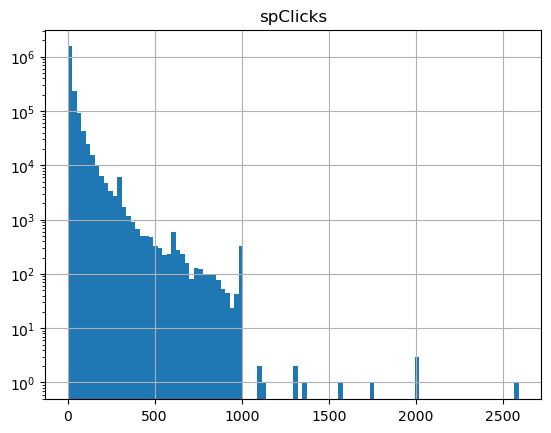

In [47]:
plt.figure(figsize=(10, 6))
combined_df.hist(column=['spClicks'], bins=100)
plt.yscale('log')


<Figure size 1000x600 with 0 Axes>

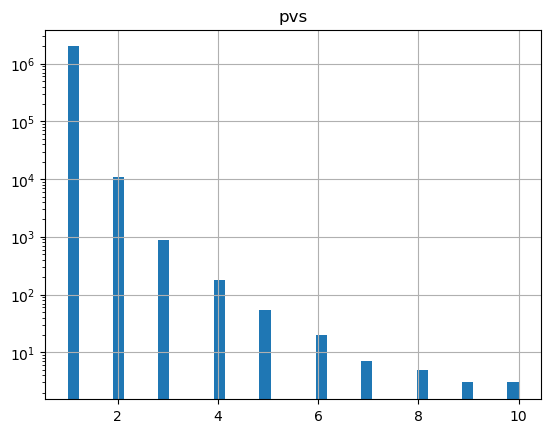

In [48]:
plt.figure(figsize=(10, 6))
combined_df.hist(column=['pvs'], bins=40)
plt.yscale('log')


In [49]:
combined_df["clicks"].value_counts()

0    1786389
1     211668
2          4
Name: clicks, dtype: int64

In [50]:
combined_df = combined_df[combined_df['clicks'] < 2]
combined_df["clicks"].value_counts()

0    1786389
1     211668
Name: clicks, dtype: int64

## handling outliers
In both spClicks and rcClicks there are clear outliers- a very small amount of samples with extremely large values.

In [51]:
z_score_rc = zscore(combined_df['rcClicks'])

combined_df = combined_df[abs(z_score_rc) <= 3.5]

<Figure size 1000x600 with 0 Axes>

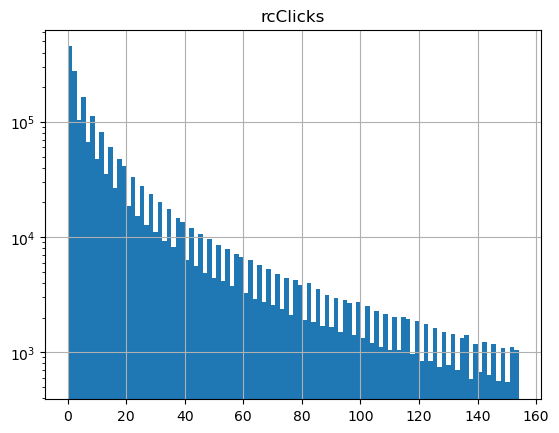

In [52]:
plt.figure(figsize=(10, 6))
combined_df.hist(column=['rcClicks'], bins= 100)
plt.yscale('log')


In [53]:
z_score_sp = zscore(combined_df['spClicks'])

combined_df = combined_df[abs(z_score_sp) <= 3.5]

<Figure size 1000x600 with 0 Axes>

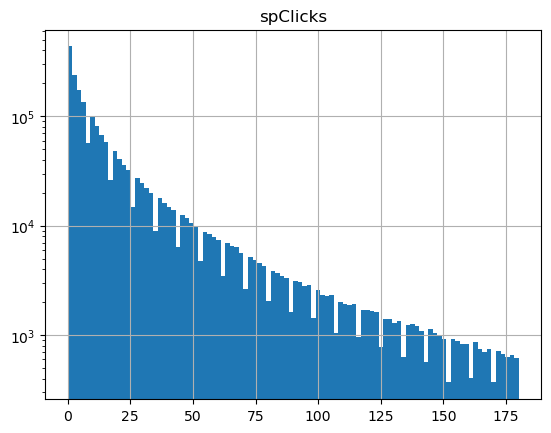

In [54]:
plt.figure(figsize=(10, 6))
combined_df.hist(column=['spClicks'], bins= 100)
plt.yscale('log')

# Limit Sparse Features

In [55]:
def limit_sparse_feature(feature_name, threshold):
    feature_counts = combined_df[feature_name].value_counts()

    values_to_replace = feature_counts[feature_counts < threshold].index

    combined_df[feature_name] = combined_df[feature_name].replace(values_to_replace, 'OTHER')


In [56]:
limit_sparse_feature("country", 5)

In [73]:
def get_feature_sparsity_percent(feature_name, threshold):
    df_len = len(combined_df)
    feature_counts = combined_df[feature_name].value_counts()
    values_to_replace = feature_counts[feature_counts < threshold].index
    sparse_count = len(combined_df[combined_df[feature_name].isin(values_to_replace)])
    return sparse_count / df_len * 100

In [88]:
get_feature_sparsity_percent("region", 10)

0.08241476822980529

In [89]:
limit_sparse_feature('region', 10)

# version

In [60]:
combined_df.to_csv("mid-processed-data.csv", index=False)

In [17]:
combined_df = pd.read_csv("mid-processed-data.csv")

In [152]:
merged_df.to_csv("data+publisher-common-features-merged.csv", index=False)

In [8]:
merged_df = pd.read_csv("data+publisher-common-features-merged.csv")

In [153]:
combined_df.to_csv("combined_df11-02 version.csv", index=False)

In [9]:
combined_df = pd.read_csv("combined_df11-02 version.csv")

# Feature Engineering

### Is Weekend

In [107]:
friday_saturday_countries = ["ISRAEL", "SAUDI ARABIA", "UNITED ARAB EMIRATES", "BAHRAIN", "QATAR"]
thursday_friday_countries = ["IRAN", "OMAN", "KUWAIT"]
saturday_sunday_dates = pd.to_datetime([20231230, 20231231], format="%Y%m%d")
friday_saturday_dates = pd.to_datetime([20231230, 20240105, 20240106], format="%Y%m%d")
thursday_friday_dates = pd.to_datetime([20240104, 20240105], format="%Y%m%d")

In [108]:
combined_df['is_weekend'] = ((combined_df['country'].isin(friday_saturday_countries)) & combined_df['date'].isin(friday_saturday_dates)) | \
                   ((combined_df['country'].isin(thursday_friday_countries)) & combined_df['date'].isin(thursday_friday_dates)) | \
                   ((~combined_df['country'].isin(thursday_friday_countries)) & (~combined_df['country'].isin(friday_saturday_countries)) & combined_df['date'].isin(saturday_sunday_dates))

In [110]:
combined_df['is_weekend'] = combined_df['is_weekend'].astype('int32')

### Taxonomy Match Feature

In [18]:
def is_in_taxonomies(row):
    if row["upperTaxonomy"] in row["sourceUpperTaxonomy"]:
        return 1
    return 0

combined_df["upper_taxonomy_match"] = combined_df.apply(is_in_taxonomies, axis=1)

In [28]:
def alchemy_taxonomy_match(row):
    subjects = row["alchemyTaxonomy"].split('/')
    for i, sub in enumerate(subjects[1:]):
        if not sub in row["sourceAlchemyTaxonomy"]:
            return i
    return len(subjects)-1

combined_df["alchemy_taxonomy_match"] = combined_df.apply(alchemy_taxonomy_match, axis=1)

### create a merged data frame of top 5 common user feature for every feature

In [32]:
pub_com_users.columns

Index(['publisherId', 'publisher_name', 'feature', 'top_5_common_user_feature',
       'top_5_feature_explained_pv', 'total_pvs', 'total_pv_clicks'],
      dtype='object')

In [33]:
publisher_id_name = pub_com_users[["publisherId", "publisher_name"]].drop_duplicates()
pub_com_users.drop(["publisher_name"], axis=1,  inplace=True)

In [34]:
pub_com_country_users = pub_com_users[pub_com_users["feature"] == "COMMON_USER_COUNTRY"]
pub_com_region_users = pub_com_users[pub_com_users["feature"] == "COMMON_USER_REGION"]
pub_com_region_code_users = pub_com_users[pub_com_users["feature"] == "COMMON_USER_REGION_CODE"]
pub_com_city_users = pub_com_users[pub_com_users["feature"] == "COMMON_USER_CITY"]
pub_com_upp_tax_users = pub_com_users[pub_com_users["feature"] == "COMMON_SOURCE_UPPER_TAXONOMY"]
pub_com_dma_users = pub_com_users[pub_com_users["feature"] == "COMMON_USER_DMA"]

In [35]:
pub_com_country_users = pub_com_country_users.add_suffix("_country")
pub_com_region_users = pub_com_region_users.add_suffix("_region")
pub_com_region_code_users = pub_com_region_code_users.add_suffix("_region_code")
pub_com_city_users = pub_com_city_users.add_suffix("_city")
pub_com_dma_users = pub_com_dma_users.add_suffix("_dma")
pub_com_upp_tax_users = pub_com_upp_tax_users.add_suffix("_upp_tax")

In [36]:
merged_df_1 = pd.merge(combined_df, pub_com_country_users, left_on='publisherId', right_on='publisherId_country', how='left')
merged_df_2 = pd.merge(merged_df_1, pub_com_region_users, left_on='publisherId', right_on='publisherId_region', how='left')
merged_df_3 = pd.merge(merged_df_2, pub_com_region_code_users, left_on='publisherId', right_on='publisherId_region_code', how='left')
merged_df_4 = pd.merge(merged_df_3, pub_com_city_users, left_on='publisherId', right_on='publisherId_city', how='left')
merged_df_5 = pd.merge(merged_df_4, pub_com_upp_tax_users, left_on='publisherId', right_on='publisherId_upp_tax', how='left')
merged_df = pd.merge(merged_df_5, pub_com_dma_users, left_on='publisherId', right_on='publisherId_dma', how='left')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1932906 entries, 0 to 1932905
Data columns (total 61 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   sourceItemId                            int64  
 1   itemId                                  int64  
 2   placement                               object 
 3   userId                                  object 
 4   publisherId                             object 
 5   publisherLanguage                       object 
 6   city                                    object 
 7   region                                  object 
 8   country                                 object 
 9   dma                                     int64  
 10  sourceUpperTaxonomy                     object 
 11  sourceAlchemyTaxonomy                   object 
 12  sessionReferrer                         object 
 13  userQualityLoyalty                      object 
 14  upperTaxonomy                     

In [44]:
del merged_df_1
del merged_df_2
del merged_df_3
del merged_df_4
del merged_df_5

In [112]:
feat_list = ["country", "region", "region_code", "city", "upp_tax", "dma"]
for feat in feat_list:
    merged_df["pvs_clicks_ratio_" + feat] = merged_df["total_pv_clicks_" + feat] / merged_df["total_pvs_" + feat]

### Calculate In Marketness

Option #1 binary feature for city/region/country

In [27]:
merged_df["top_5_common_user_feature_city"] = merged_df["top_5_common_user_feature_city"].astype('str')
merged_df["top_5_common_user_feature_country"] = merged_df["top_5_common_user_feature_country"].astype('str')
merged_df["top_5_common_user_feature_region"] = merged_df["top_5_common_user_feature_region"].astype('str')
merged_df["top_5_common_user_feature_region_code"] = merged_df["top_5_common_user_feature_region_code"].astype('str')
merged_df["top_5_common_user_feature_upp_tax"] = merged_df["top_5_common_user_feature_upp_tax"].astype('str')
merged_df["top_5_common_user_feature_dma"] = merged_df["top_5_common_user_feature_dma"].astype('str')

def in_city_condition(row):
    if row['city'] in row['top_5_common_user_feature_city']:
        return 1
    return 0

def in_country_condition(row):
    if row['country'] in row['top_5_common_user_feature_country']:
        return 1
    return 0

def in_region_condition(row):
    if row['region'] in row['top_5_common_user_feature_region'] or row['region'] in row['top_5_common_user_feature_region_code']:
        return 1
    return 0

def in_dma_condition(row):
    if row['region'] in row['top_5_common_user_feature_dma'] or row['country'] in row['top_5_common_user_feature_dma']:
        return 1
    return 0

merged_df['in_country_user'] = merged_df.apply(in_city_condition, axis=1)
merged_df['in_country_user'] = merged_df.apply(in_country_condition, axis=1)
merged_df['in_region_user'] = merged_df.apply(in_region_condition, axis=1)
merged_df['in_dma_user'] = merged_df.apply(in_dma_condition, axis=1)


In [28]:
merged_df = merged_df.drop(pub_com_city_users.columns, axis=1)
merged_df = merged_df.drop(pub_com_country_users.columns, axis=1)
merged_df = merged_df.drop(pub_com_region_users.columns, axis=1)
merged_df = merged_df.drop(pub_com_region_code_users.columns, axis=1)
merged_df = merged_df.drop(pub_com_dma_users.columns, axis=1)
merged_df = merged_df.drop(pub_com_upp_tax_users.columns, axis=1)


option #2 one feature for im marketness- 1 for in country user, 2 for in region user, 3 for in city user

In [78]:
merged_df["top_5_common_user_feature_city"] = merged_df["top_5_common_user_feature_city"].astype('str')
merged_df["top_5_common_user_feature_country"] = merged_df["top_5_common_user_feature_country"].astype('str')
merged_df["top_5_common_user_feature_region"] = merged_df["top_5_common_user_feature_region"].astype('str')
merged_df["top_5_common_user_feature_region_code"] = merged_df["top_5_common_user_feature_region_code"].astype('str')
merged_df["top_5_common_user_feature_upp_tax"] = merged_df["top_5_common_user_feature_upp_tax"].astype('str')
merged_df["top_5_common_user_feature_dma"] = merged_df["top_5_common_user_feature_dma"].astype('str')


def calc_in_marketness(row):
    in_marketness = 0
    if row['country'] in row['top_5_common_user_feature_country']:
        in_marketness = in_marketness + 1
    if row['region'] in row['top_5_common_user_feature_region'] or row['region'] in row['top_5_common_user_feature_region_code']:
        in_marketness = in_marketness + 1
    if row['city'] in row['top_5_common_user_feature_city']:
        in_marketness = in_marketness + 1
    return in_marketness

def in_dma_condition(row):
    if str(row['dma']) in row['top_5_common_user_feature_dma']:
        return 1
    return 0

merged_df['in_dma_user'] = merged_df.apply(in_dma_condition, axis=1)

merged_df['in_market_user'] = merged_df.apply(calc_in_marketness, axis=1)

In [82]:
merged_df = merged_df.drop(["publisherId_country", "publisherId_city", "publisherId_region", "publisherId_region", "publisherId_region_code", "publisherId_upp_tax", "publisherId_dma"], axis=1)
merged_df = merged_df.drop(["feature_country", "feature_city", "feature_region", "feature_region_code", "feature_dma", "feature_upp_tax"], axis=1)

## Calculate Item Clicks History Ratio
did not finish after reasonable time

In [41]:
combined_df['clicks_before'] = 0
combined_df['appearances_before'] = 0
legnth_div_100 = len(combined_df) // 100
counter = 0
for index , row in combined_df.iterrows():
    counter += 1
    item_id = row['itemId']
    date = row['date']
    
    appearances_sub_df = combined_df[(combined_df['itemId'] == item_id) & (combined_df['date'] < date)]
    appearances_before = len(appearances_sub_df)
    clicks_before = len(appearances_sub_df[appearances_sub_df['clicks'] == 1])

    if counter % legnth_div_100 == 99:
        print(f"finished {counter // legnth_div_100} / 100 with clicks before: {clicks_before}")
    
    if appearances_before != 0: 
        ratio = clicks_before / appearances_before
    else:
        ratio = 0
    
    combined_df.at[index, 'clicks_before'] = clicks_before
    combined_df.at[index, 'appearances_before'] = appearances_before
    combined_df.at[index, 'item_history_clicks_ratio'] = ratio

combined_df.drop(['appearances_before', 'clicks_before'], axis=1, inplace=True)

finished 0 / 100 with clicks before: 0


KeyboardInterrupt: 

## Add an is_TAXONOMY_publisher features

In [83]:
taxonomies = merged_df["upperTaxonomy"].value_counts().keys()
for tax in taxonomies:
    feature_name = "is_" + tax + "_publisher"
    merged_df[feature_name] = merged_df["sourceUpperTaxonomy"].apply(lambda s: tax in str(s))
    merged_df[feature_name] = merged_df[feature_name].astype(int)


## drop rows with missing values

In [86]:
missing_cols(merged_df)

top_5_feature_explained_pv_country => 33483
total_pvs_country => 33483
total_pv_clicks_country => 33483
top_5_feature_explained_pv_region => 33483
total_pvs_region => 33483
total_pv_clicks_region => 33483
top_5_feature_explained_pv_region_code => 33483
total_pvs_region_code => 33483
total_pv_clicks_region_code => 33483
top_5_feature_explained_pv_city => 33483
total_pvs_city => 33483
total_pv_clicks_city => 33483
top_5_feature_explained_pv_upp_tax => 33529
total_pvs_upp_tax => 33529
total_pv_clicks_upp_tax => 33529
top_5_feature_explained_pv_dma => 183963
total_pvs_dma => 183963
total_pv_clicks_dma => 183963


In [91]:
merged_df = merged_df.dropna(subset=['top_5_feature_explained_pv_country', 'top_5_feature_explained_pv_region', 'top_5_feature_explained_pv_region_code', 'top_5_feature_explained_pv_city', 'top_5_feature_explained_pv_upp_tax', 'top_5_feature_explained_pv_dma'])
missing_cols(merged_df)
print("number of rows left in df: ", len(merged_df))

no missing values left
number of rows left in df:  1748929


# CatBoost Model

In [113]:
data = merged_df

In [114]:
data.columns

Index(['sourceItemId', 'itemId', 'placement', 'userId', 'publisherId',
       'publisherLanguage', 'city', 'region', 'country', 'dma',
       'sourceUpperTaxonomy', 'sourceAlchemyTaxonomy', 'sessionReferrer',
       'userQualityLoyalty', 'upperTaxonomy', 'alchemyTaxonomy', 'rcClicks',
       'spClicks', 'date', 'clicks', 'pvs', 'session_depth', 'is_weekend',
       'upper_taxonomy_match', 'alchemy_taxonomy_match',
       'top_5_common_user_feature_country',
       'top_5_feature_explained_pv_country', 'total_pvs_country',
       'total_pv_clicks_country', 'top_5_common_user_feature_region',
       'top_5_feature_explained_pv_region', 'total_pvs_region',
       'total_pv_clicks_region', 'top_5_common_user_feature_region_code',
       'top_5_feature_explained_pv_region_code', 'total_pvs_region_code',
       'total_pv_clicks_region_code', 'top_5_common_user_feature_city',
       'top_5_feature_explained_pv_city', 'total_pvs_city',
       'total_pv_clicks_city', 'top_5_common_user_feature_

In [115]:
data = data.drop(['sourceItemId', 'itemId','userId', 'publisherId'], axis=1)

### Split Train Test

In [116]:
labels = data['clicks']
data = data.drop('clicks', axis=1)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size= 0.2, random_state=42)

### Create And Fit Model

In [118]:
model = CatBoostClassifier(depth=6,  learning_rate= 0.1, num_trees=40 , cat_features= ['placement', 'publisherLanguage', 'city', 'region', 'country','dma','sourceUpperTaxonomy', 'sourceAlchemyTaxonomy', 'sessionReferrer', 'userQualityLoyalty', 'upperTaxonomy', 'alchemyTaxonomy', "date", 'top_5_common_user_feature_country',
        'top_5_common_user_feature_region',
        'top_5_common_user_feature_region_code',
        'top_5_common_user_feature_city',
        'top_5_common_user_feature_upp_tax',
        'top_5_common_user_feature_dma'])

In [119]:
model.fit(X_train, y_train)

0:	learn: 0.6082413	total: 1.05s	remaining: 41s
1:	learn: 0.5429032	total: 2.02s	remaining: 38.3s
2:	learn: 0.4926579	total: 3.08s	remaining: 38s
3:	learn: 0.4541060	total: 4.28s	remaining: 38.5s
4:	learn: 0.4232232	total: 5.18s	remaining: 36.3s
5:	learn: 0.4001965	total: 6.07s	remaining: 34.4s
6:	learn: 0.3833771	total: 6.39s	remaining: 30.1s
7:	learn: 0.3680809	total: 7.36s	remaining: 29.4s
8:	learn: 0.3567234	total: 8.3s	remaining: 28.6s
9:	learn: 0.3483032	total: 9.28s	remaining: 27.8s
10:	learn: 0.3408201	total: 10.2s	remaining: 26.9s
11:	learn: 0.3355724	total: 10.6s	remaining: 24.8s
12:	learn: 0.3309206	total: 11.5s	remaining: 23.9s
13:	learn: 0.3275502	total: 12.4s	remaining: 23.1s
14:	learn: 0.3241883	total: 13.3s	remaining: 22.1s
15:	learn: 0.3215364	total: 14.1s	remaining: 21.2s
16:	learn: 0.3195188	total: 15s	remaining: 20.3s
17:	learn: 0.3177535	total: 16.1s	remaining: 19.7s
18:	learn: 0.3165864	total: 17.1s	remaining: 18.9s
19:	learn: 0.3155150	total: 18s	remaining: 18s
2

In [120]:
y_pred = model.predict(X_test)

In [121]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8987666744809684

100 trees, depth- 6 accuracy: 0.9010875347242745
100 trees, depth- 6, with im-market user: 0.9011377741001241
200 trees, depth- 6 accuracy: 0.901403747266387
200 trees, depth- 6, with im-market user: 0.9013475973757314


## Model V2

### Dropping Irrelevant Features

In [279]:
data_V2 = combined_df_v2.drop(['userId', 'publisherId', 'itemId', 'sourceItemId', 'date'], axis=1)
labels_V2 = data_V2['clicks']
data_V2 = data_V2.drop('clicks', axis=1)

### Split Train Test

In [281]:
X_train_V2, X_test_V2, y_train_V2, y_test_V2 = train_test_split(data_V2, labels_V2, test_size= 0.2, random_state=42)

### Create And Fit Model

In [299]:
cat_features_indices = ['placement', 'publisherLanguage', 'city', 'region', 'country', 'sessionReferrer', 'userQualityLoyalty', 'upperTaxonomy', 'alchemyTaxonomy']

In [304]:
model_V2 = CatBoostClassifier(iterations=30, depth=3, learning_rate= 0.1, cat_features= ['placement', 'publisherLanguage', 'city', 'region', 'country', 'sessionReferrer', 'userQualityLoyalty', 'upperTaxonomy', 'alchemyTaxonomy'])

In [305]:
model_V2.fit(X_train_V2, y_train_V2)

0:	learn: 0.6316216	total: 686ms	remaining: 19.9s
1:	learn: 0.5817498	total: 898ms	remaining: 12.6s
2:	learn: 0.5401440	total: 1.6s	remaining: 14.4s
3:	learn: 0.5055643	total: 1.97s	remaining: 12.8s
4:	learn: 0.4765570	total: 2.45s	remaining: 12.3s
5:	learn: 0.4521165	total: 2.72s	remaining: 10.9s
6:	learn: 0.4314439	total: 3.17s	remaining: 10.4s
7:	learn: 0.4139200	total: 3.52s	remaining: 9.68s
8:	learn: 0.3989454	total: 3.93s	remaining: 9.16s
9:	learn: 0.3862857	total: 4.35s	remaining: 8.7s
10:	learn: 0.3753567	total: 4.76s	remaining: 8.23s
11:	learn: 0.3659587	total: 5.3s	remaining: 7.95s
12:	learn: 0.3583830	total: 5.51s	remaining: 7.2s
13:	learn: 0.3515141	total: 5.95s	remaining: 6.8s
14:	learn: 0.3456411	total: 6.47s	remaining: 6.47s
15:	learn: 0.3406444	total: 6.89s	remaining: 6.03s
16:	learn: 0.3365242	total: 7.35s	remaining: 5.62s
17:	learn: 0.3328547	total: 7.77s	remaining: 5.18s
18:	learn: 0.3298238	total: 8.21s	remaining: 4.75s
19:	learn: 0.3272537	total: 8.56s	remaining: 4

In [306]:
y_pred_V2 = model_V2.predict(X_test_V2)


In [307]:
accuracy_V2 = accuracy_score(y_test_V2, y_pred_V2)
accuracy_V2

0.9010136532892015

## Visualize Feature Importance

In [122]:
feature_importance = model.get_feature_importance()
features = data.columns
for i, importance in enumerate(feature_importance):
    print(f"{features[i]}: Importance = {round(importance, 2)}")

placement: Importance = 18.43
publisherLanguage: Importance = 0.87
city: Importance = 0.0
region: Importance = 0.0
country: Importance = 0.0
dma: Importance = 0.03
sourceUpperTaxonomy: Importance = 1.12
sourceAlchemyTaxonomy: Importance = 0.23
sessionReferrer: Importance = 0.0
userQualityLoyalty: Importance = 0.1
upperTaxonomy: Importance = 0.29
alchemyTaxonomy: Importance = 4.43
rcClicks: Importance = 32.48
spClicks: Importance = 0.84
date: Importance = 0.0
pvs: Importance = 0.05
session_depth: Importance = 0.52
is_weekend: Importance = 0.0
upper_taxonomy_match: Importance = 0.48
alchemy_taxonomy_match: Importance = 0.22
top_5_common_user_feature_country: Importance = 6.87
top_5_feature_explained_pv_country: Importance = 0.0
total_pvs_country: Importance = 0.17
total_pv_clicks_country: Importance = 0.75
top_5_common_user_feature_region: Importance = 0.0
top_5_feature_explained_pv_region: Importance = 0.17
total_pvs_region: Importance = 0.0
total_pv_clicks_region: Importance = 0.11
top

### feature importace with in market user feature:

sourceItemId: Importance = 3.88
itemId: Importance = 17.34
placement: Importance = 17.22
userId: Importance = 4.53
publisherId: Importance = 24.13
publisherLanguage: Importance = 0.85
city: Importance = 0.06
region: Importance = 0.05
country: Importance = 1.07
sessionReferrer: Importance = 0.28
userQualityLoyalty: Importance = 0.47
upperTaxonomy: Importance = 0.4
alchemyTaxonomy: Importance = 2.25
rcClicks: Importance = 25.32
spClicks: Importance = 1.15
date: Importance = 0.0
pvs: Importance = 0.24
session_depth: Importance = 0.74
weekend: Importance = 0.0
in_market_user: Importance = 0.0

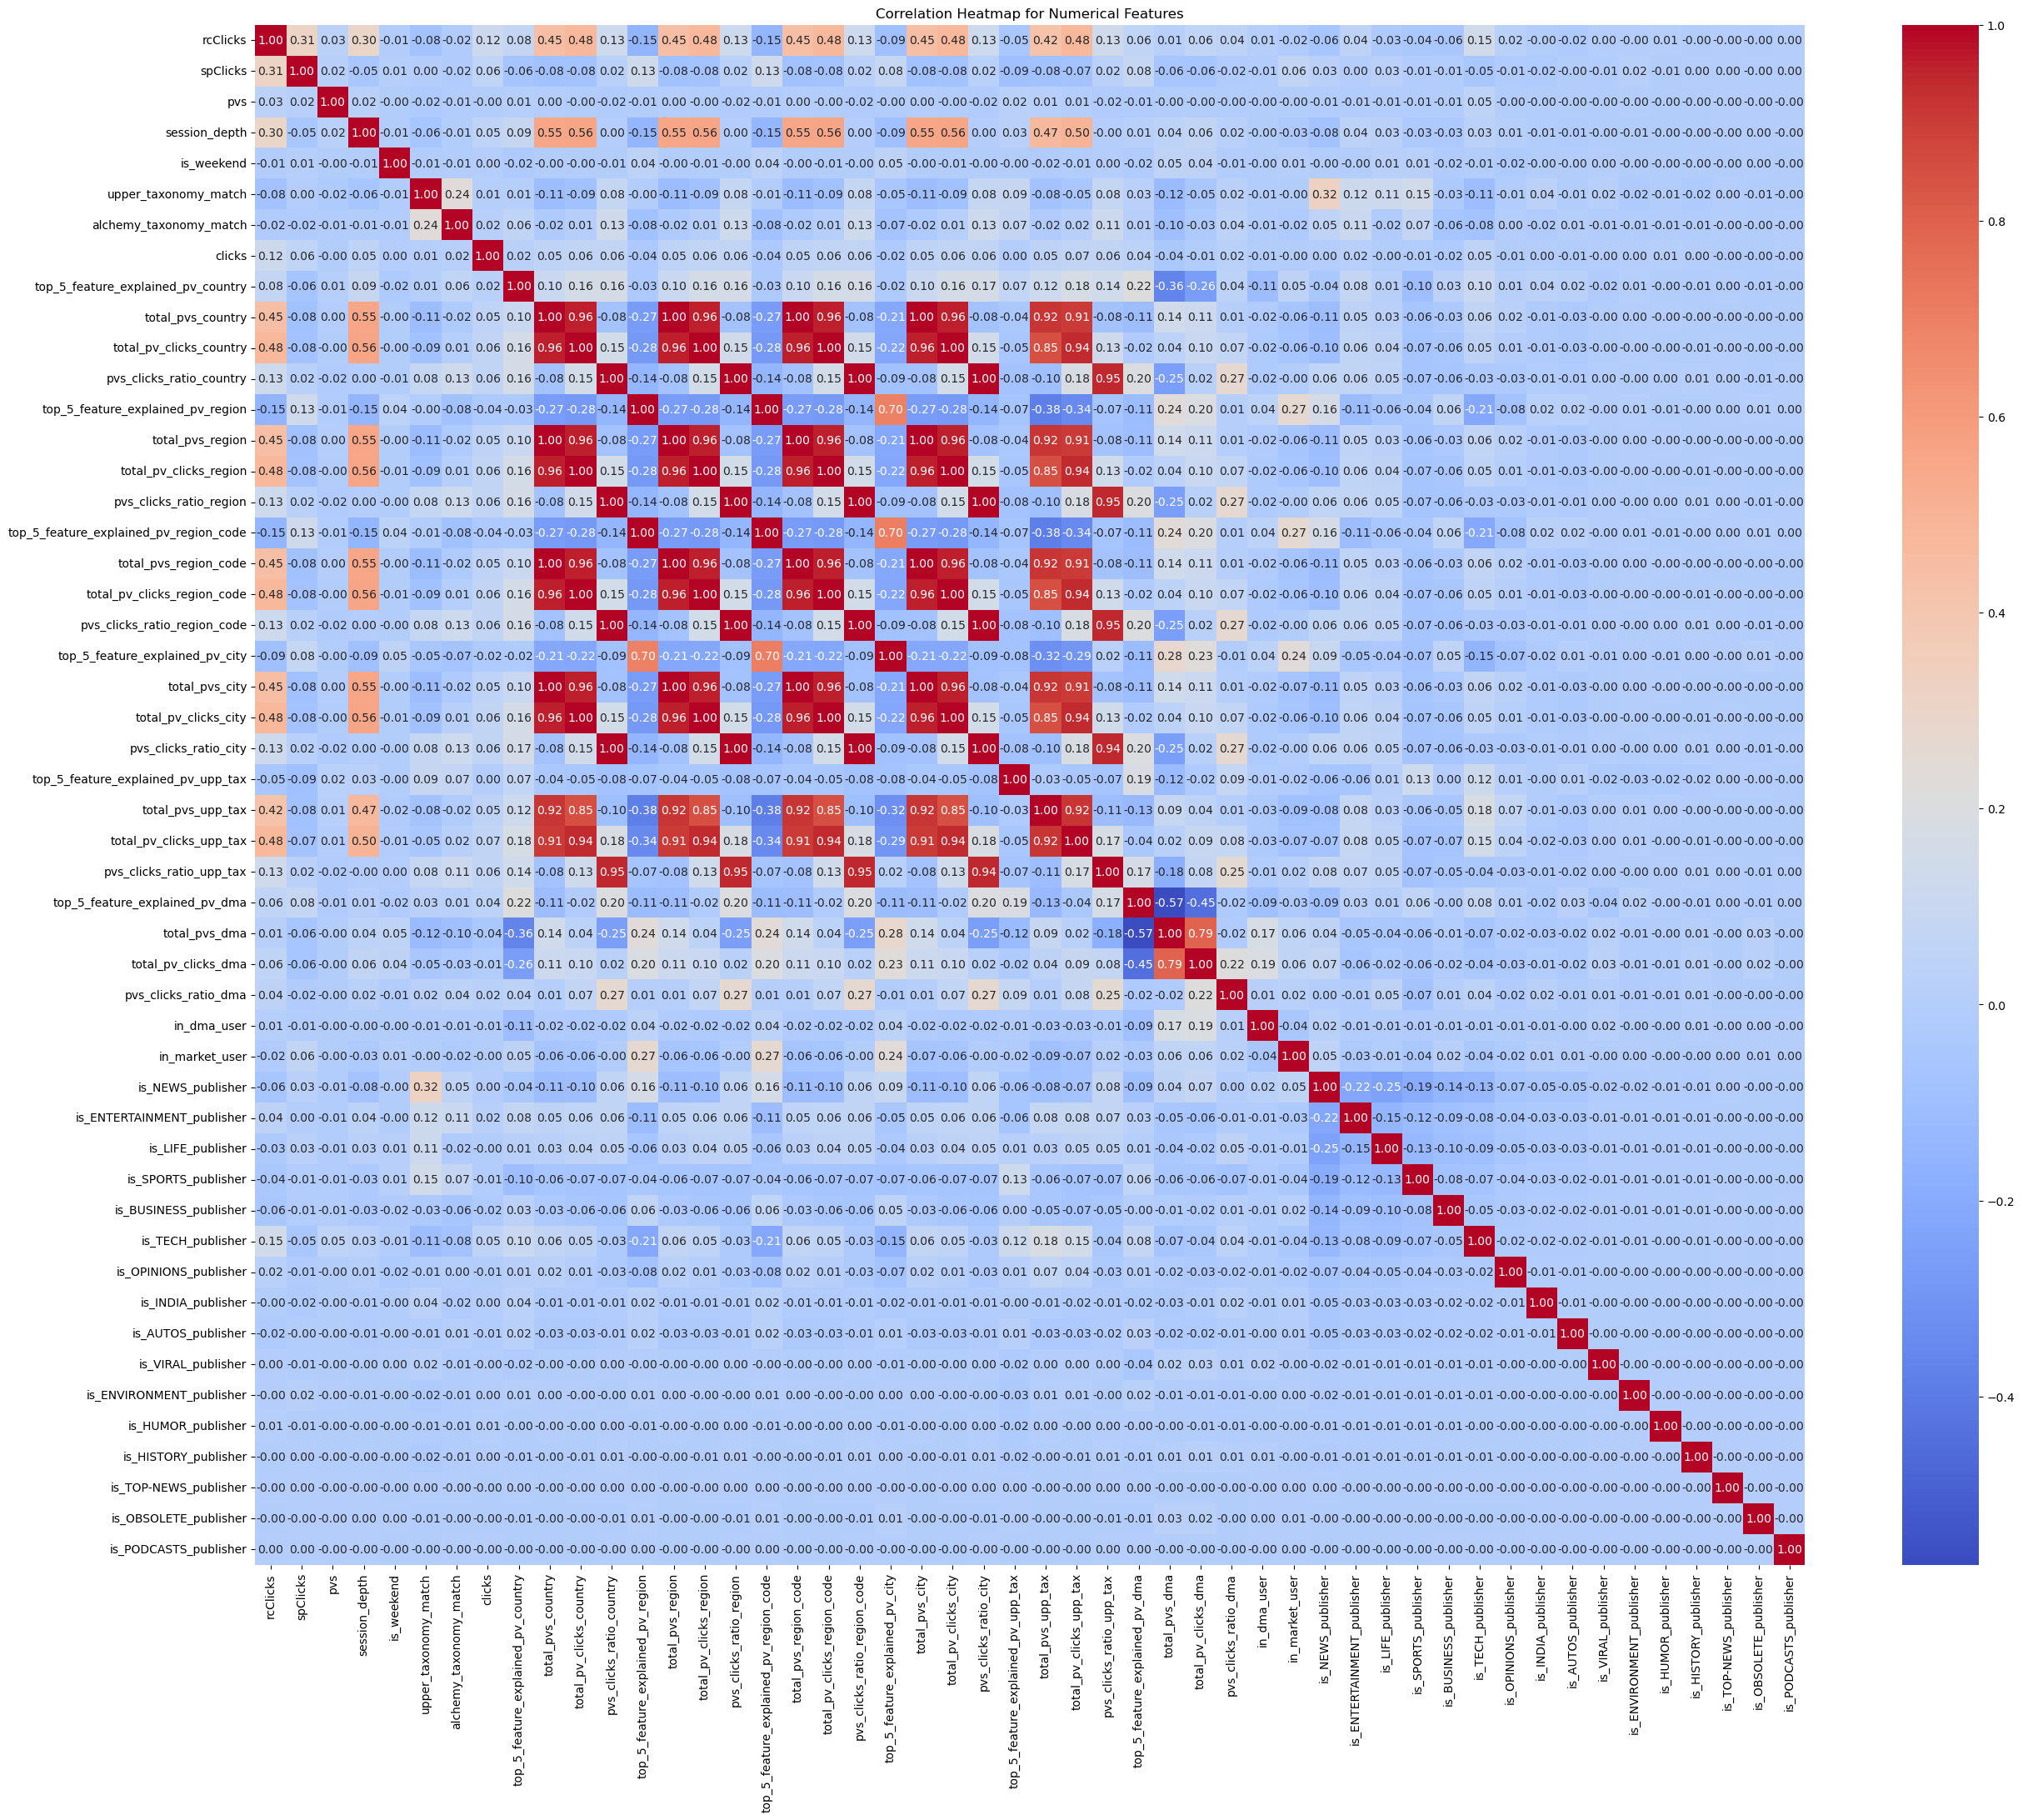

In [123]:
numerical_features = ['rcClicks',
       'spClicks', 'pvs', 'session_depth', 'is_weekend',
       'upper_taxonomy_match', 'alchemy_taxonomy_match', "clicks",
       'top_5_feature_explained_pv_country', 'total_pvs_country',
       'total_pv_clicks_country', 'pvs_clicks_ratio_country',
       'top_5_feature_explained_pv_region', 'total_pvs_region',
       'total_pv_clicks_region', 'pvs_clicks_ratio_region',
       'top_5_feature_explained_pv_region_code', 'total_pvs_region_code',
       'total_pv_clicks_region_code', 'pvs_clicks_ratio_region_code',
       'top_5_feature_explained_pv_city', 'total_pvs_city',
       'total_pv_clicks_city', 'pvs_clicks_ratio_city',
       'top_5_feature_explained_pv_upp_tax', 'total_pvs_upp_tax',
       'total_pv_clicks_upp_tax', 'pvs_clicks_ratio_upp_tax', 
       'top_5_feature_explained_pv_dma', 'total_pvs_dma',
       'total_pv_clicks_dma', 'pvs_clicks_ratio_dma', 'in_dma_user', 'in_market_user',
       'is_NEWS_publisher', 'is_ENTERTAINMENT_publisher', 'is_LIFE_publisher',
       'is_SPORTS_publisher', 'is_BUSINESS_publisher', 'is_TECH_publisher',
       'is_OPINIONS_publisher', 'is_INDIA_publisher', 'is_AUTOS_publisher',
       'is_VIRAL_publisher', 'is_ENVIRONMENT_publisher', 'is_HUMOR_publisher',
       'is_HISTORY_publisher', 'is_TOP-NEWS_publisher',
       'is_OBSOLETE_publisher', 'is_PODCASTS_publisher']
numerical_features_corr = merged_df[numerical_features].corr()

plt.figure(figsize=(30, 24))
sns.heatmap(numerical_features_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Numerical Features')
plt.show()

# Run DeepFm Model

In [135]:
deepfm_data = merged_df

In [136]:
deepfm_data = deepfm_data.drop(['sourceItemId', 'itemId', 'userId', 'publisherId'], axis=1)

In [137]:
sparse_features = ['placement', 'publisherLanguage', 'city', 'region', 'country','dma','sourceUpperTaxonomy', 'sourceAlchemyTaxonomy', 'sessionReferrer', 'userQualityLoyalty', 'upperTaxonomy', 'alchemyTaxonomy', "date", 'top_5_common_user_feature_country',
        'top_5_common_user_feature_region',
        'top_5_common_user_feature_region_code',
        'top_5_common_user_feature_city',
        'top_5_common_user_feature_upp_tax',
        'top_5_common_user_feature_dma']
dense_features = set(deepfm_data.columns).difference(sparse_features)

target = ['clicks']

In [139]:
for feat in sparse_features:
    lbe = LabelEncoder()
    deepfm_data[feat] = lbe.fit_transform(deepfm_data[feat])
    
dense_features = list(dense_features)
mms = MinMaxScaler(feature_range=(0,1))
deepfm_data[dense_features] = mms.fit_transform(deepfm_data[dense_features])

In [146]:
fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=deepfm_data[feat].max() + 1,embedding_dim=10)
                       for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]

In [147]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [148]:
train, test = train_test_split(deepfm_data, test_size=0.2, shuffle=False)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}


model = DeepFM(linear_feature_columns,dnn_feature_columns,task='binary')
model.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'], )


In [149]:

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=4, verbose=2, validation_split=0.2,shuffle=False )


Train on 1119314 samples, validate on 279829 samples
Epoch 1/4


c:\Users\ofri\anaconda3\envs\starship2.0\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\ofri\anaconda3\envs\starship2.0\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1119314/1119314 - 162s - loss: 0.0040 - binary_crossentropy: 0.0040 - val_loss: 1.3897e-05 - val_binary_crossentropy: 1.8340e-08
Epoch 2/4
1119314/1119314 - 146s - loss: 8.8828e-06 - binary_crossentropy: 4.4713e-09 - val_loss: 4.2194e-06 - val_binary_crossentropy: 8.2795e-10
Epoch 3/4
1119314/1119314 - 149s - loss: 1.6524e-06 - binary_crossentropy: 1.8915e-10 - val_loss: 2.2958e-07 - val_binary_crossentropy: 5.1760e-11
Epoch 4/4
1119314/1119314 - 148s - loss: 3.9767e-08 - binary_crossentropy: 1.3153e-11 - val_loss: 8.3701e-12 - val_binary_crossentropy: 4.6861e-12


In [70]:
model.save_weights('DeepFM_w.h5')

In [61]:
for feat in test_model_input.keys():
    test_model_input[feat] = np.array([float(x) for x in test_model_input[feat]])

In [150]:
pred_ans = model.predict(test_model_input, batch_size=256)

In [151]:
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test LogLoss nan
test AUC 1.0


c:\Users\ofri\anaconda3\envs\starship2.0\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
c:\Users\ofri\anaconda3\envs\starship2.0\lib\site-packages\sklearn\metrics\_classification.py:2442: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
